In [1]:
import librosa
from librosa import display
import os
import pandas as pd
import glob 
import matplotlib.pyplot as plt
import numpy as np


In [2]:
data, sampling_rate = librosa.load('C:/voice/Actor_01/03-01-01-01-01-01-01.wav')

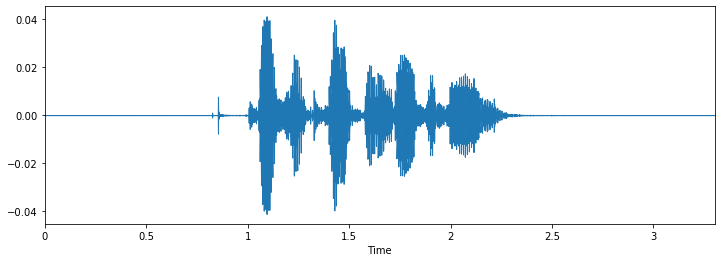

In [3]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [4]:
import time

path = 'C:/voice/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 85.84619164466858 seconds ---


In [6]:
X, y = zip(*lst)

In [7]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1440, 40), (1440,))

In [8]:
import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'C:/another_model/'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [9]:
X = joblib.load('C:/another_model/X.joblib')
y = joblib.load('C:/another_model/y.joblib')

In [10]:
#Neural net

In [11]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [17]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [18]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_5 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)            0         
__________

In [19]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [20]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1152 samples, validate on 288 samples
Epoch 1/1000





1152/1152 [==============================] - 1s 953us/step - loss: 9.3874 - acc: 0.1502 - val_loss: 7.2822 - val_acc: 0.1736
Epoch 2/1000
1152/1152 [==============================] - 1s 435us/step - loss: 9.0942 - acc: 0.1424 - val_loss: 7.3296 - val_acc: 0.1493
Epoch 3/1000
1152/1152 [==============================] - 0s 405us/step - loss: 8.3651 - acc: 0.1450 - val_loss: 5.5413 - val_acc: 0.1319
Epoch 4/1000
1152/1152 [==============================] - 0s 345us/step - loss: 7.7226 - acc: 0.1493 - val_loss: 5.1241 - val_acc: 0.2049
Epoch 5/1000
1152/1152 [==============================] - 0s 316us/step - loss: 7.2191 - acc: 0.1432 - val_loss: 3.2071 - val_acc: 0.1944
Epoch 6/1000
1152/1152 [==============================] - 0s 326us/step - loss: 6.0415 - acc: 0.1441 - val_loss: 3.0445 - val_acc: 0.1944
Epoch 7/1000
1152/1152 

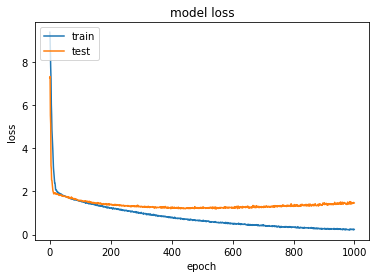

In [21]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

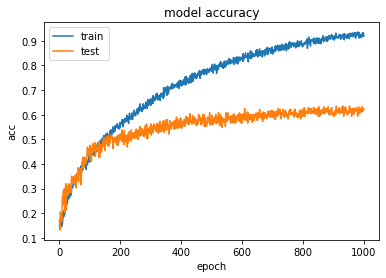

In [22]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
predictions = model.predict_classes(x_testcnn)

In [24]:
predictions

array([6, 1, 5, 1, 6, 0, 3, 5, 2, 1, 5, 7, 4, 5, 6, 6, 7, 5, 1, 2, 2, 0,
       0, 5, 5, 6, 4, 7, 6, 6, 2, 4, 7, 6, 7, 1, 6, 4, 5, 4, 1, 3, 1, 4,
       2, 1, 1, 0, 5, 4, 7, 3, 7, 4, 0, 7, 2, 7, 4, 3, 7, 5, 2, 4, 5, 4,
       1, 6, 3, 3, 2, 7, 1, 7, 6, 1, 4, 7, 3, 6, 2, 2, 5, 1, 2, 4, 5, 1,
       1, 0, 0, 1, 4, 6, 0, 6, 7, 2, 2, 7, 6, 5, 4, 5, 7, 5, 2, 6, 4, 1,
       2, 4, 7, 2, 6, 4, 5, 6, 2, 5, 6, 1, 7, 5, 3, 4, 7, 3, 5, 5, 2, 2,
       1, 5, 4, 3, 3, 6, 4, 6, 2, 6, 3, 7, 4, 6, 4, 1, 2, 5, 5, 3, 1, 5,
       5, 1, 2, 3, 7, 5, 2, 6, 4, 5, 2, 4, 4, 6, 3, 7, 1, 4, 4, 6, 4, 1,
       6, 7, 2, 6, 2, 2, 2, 3, 0, 6, 7, 4, 4, 3, 6, 5, 3, 1, 7, 3, 7, 7,
       6, 4, 2, 3, 7, 3, 1, 4, 6, 1, 2, 7, 3, 6, 7, 5, 6, 5, 2, 4, 7, 7,
       3, 6, 6, 3, 3, 6, 3, 3, 3, 0, 3, 7, 0, 6, 7, 6, 6, 6, 4, 0, 1, 1,
       7, 3, 7, 7, 0, 1, 1, 1, 4, 3, 2, 1, 4, 6, 3, 6, 1, 1, 6, 3, 1, 1,
       4, 1, 6, 3, 7, 1, 7, 1, 3, 6, 6, 2, 6, 5, 5, 6, 4, 2, 6, 6, 3, 4,
       0, 3], dtype=int64)

In [25]:
y_test

array([6, 1, 1, 1, 4, 1, 1, 5, 7, 1, 6, 7, 3, 5, 3, 6, 4, 5, 1, 6, 7, 0,
       0, 3, 5, 3, 7, 7, 6, 4, 7, 4, 2, 5, 7, 1, 6, 4, 2, 4, 1, 0, 1, 4,
       7, 1, 1, 0, 5, 3, 3, 7, 7, 4, 0, 1, 1, 7, 2, 0, 7, 5, 7, 7, 5, 2,
       1, 6, 6, 3, 2, 7, 1, 2, 7, 1, 4, 7, 3, 6, 2, 2, 7, 1, 2, 4, 5, 1,
       2, 1, 0, 1, 4, 4, 0, 6, 7, 2, 2, 7, 6, 5, 4, 5, 3, 7, 2, 6, 5, 0,
       7, 4, 7, 1, 6, 4, 5, 6, 6, 5, 6, 1, 7, 5, 3, 4, 7, 2, 5, 5, 2, 2,
       3, 5, 2, 3, 1, 1, 6, 6, 4, 4, 2, 2, 4, 2, 4, 1, 7, 5, 5, 3, 1, 5,
       2, 0, 5, 3, 7, 5, 3, 4, 4, 3, 2, 0, 4, 1, 3, 7, 1, 5, 4, 6, 5, 1,
       4, 7, 2, 3, 2, 5, 2, 3, 0, 0, 7, 4, 4, 3, 6, 5, 3, 1, 3, 5, 7, 7,
       6, 1, 5, 3, 7, 3, 1, 4, 6, 3, 2, 7, 2, 6, 7, 5, 0, 5, 4, 4, 7, 7,
       3, 7, 6, 5, 3, 6, 1, 3, 3, 0, 3, 7, 3, 6, 7, 4, 4, 6, 4, 0, 6, 1,
       7, 0, 2, 2, 0, 1, 1, 3, 4, 3, 4, 1, 4, 6, 3, 7, 1, 1, 4, 1, 1, 1,
       4, 0, 6, 7, 7, 1, 2, 0, 3, 7, 3, 4, 4, 2, 4, 2, 4, 2, 3, 6, 3, 6,
       2, 3])

In [26]:
new_Ytest = y_test.astype(int)


In [27]:

new_Ytest

array([6, 1, 1, 1, 4, 1, 1, 5, 7, 1, 6, 7, 3, 5, 3, 6, 4, 5, 1, 6, 7, 0,
       0, 3, 5, 3, 7, 7, 6, 4, 7, 4, 2, 5, 7, 1, 6, 4, 2, 4, 1, 0, 1, 4,
       7, 1, 1, 0, 5, 3, 3, 7, 7, 4, 0, 1, 1, 7, 2, 0, 7, 5, 7, 7, 5, 2,
       1, 6, 6, 3, 2, 7, 1, 2, 7, 1, 4, 7, 3, 6, 2, 2, 7, 1, 2, 4, 5, 1,
       2, 1, 0, 1, 4, 4, 0, 6, 7, 2, 2, 7, 6, 5, 4, 5, 3, 7, 2, 6, 5, 0,
       7, 4, 7, 1, 6, 4, 5, 6, 6, 5, 6, 1, 7, 5, 3, 4, 7, 2, 5, 5, 2, 2,
       3, 5, 2, 3, 1, 1, 6, 6, 4, 4, 2, 2, 4, 2, 4, 1, 7, 5, 5, 3, 1, 5,
       2, 0, 5, 3, 7, 5, 3, 4, 4, 3, 2, 0, 4, 1, 3, 7, 1, 5, 4, 6, 5, 1,
       4, 7, 2, 3, 2, 5, 2, 3, 0, 0, 7, 4, 4, 3, 6, 5, 3, 1, 3, 5, 7, 7,
       6, 1, 5, 3, 7, 3, 1, 4, 6, 3, 2, 7, 2, 6, 7, 5, 0, 5, 4, 4, 7, 7,
       3, 7, 6, 5, 3, 6, 1, 3, 3, 0, 3, 7, 3, 6, 7, 4, 4, 6, 4, 0, 6, 1,
       7, 0, 2, 2, 0, 1, 1, 3, 4, 3, 4, 1, 4, 6, 3, 7, 1, 1, 4, 1, 1, 1,
       4, 0, 6, 7, 7, 1, 2, 0, 3, 7, 3, 4, 4, 2, 4, 2, 4, 2, 3, 6, 3, 6,
       2, 3])

In [28]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       0.78      0.70      0.74        44
           2       0.44      0.44      0.44        34
           3       0.59      0.56      0.58        39
           4       0.65      0.62      0.63        42
           5       0.70      0.72      0.71        32
           6       0.49      0.78      0.60        32
           7       0.72      0.62      0.67        45

    accuracy                           0.62       288
   macro avg       0.64      0.62      0.62       288
weighted avg       0.64      0.62      0.63       288



In [29]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)


[[10  4  0  3  1  0  2  0]
 [ 2 31  2  4  1  1  2  1]
 [ 1  1 15  3  3  3  2  6]
 [ 1  3  1 22  2  2  5  3]
 [ 0  0  4  0 26  1 10  1]
 [ 0  0  3  2  3 23  1  0]
 [ 0  1  2  1  2  1 25  0]
 [ 0  0  7  2  2  2  4 28]]


In [30]:
#Save the model---/
model_name = 'Emotion_Voice_model_relu.h5'
save_dir = 'C:/another_model/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:/another_model/Emotion_Voice_model_relu.h5 


In [31]:
#load model

In [32]:
loaded_model = keras.models.load_model('C:/another_model/Emotion_Voice_model_relu.h5')
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_4 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_5 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)            0         
__________

In [33]:
oss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

288/288 [==============================] - 0s 540us/step
Restored model, accuracy: 62.50%
